# Variational AutoEncoder (VAE)

I will try to implement a VAE with [this](https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f) online resources.
I have also read [this](https://medium.com/@weidagang/demystifying-neural-networks-variational-autoencoders-6a44e75d0271)
 medium article about the idea and motivations about VAE. Although this article also include a tutorial for implementing the VAE. However, it is based
on tensorflow and keras, so I have switched to the other one.

## Import

This is the import of the required libraries. Most of them are quite typical.

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as v2
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

## Dataset

We can directly use the MNIST dataset in-built to pytorch.

In [2]:
# create a transform to apply to each datapoint
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

# download the MNIST datasets
path = '../data/mnist'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset = MNIST(path, transform=transform, download=True)

# Create train and test dataloaders
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# The device
device = torch.device("mps" if torch.mps.is_available() else "cpu")

### Visualisation

Now, we can visualise some of the training data

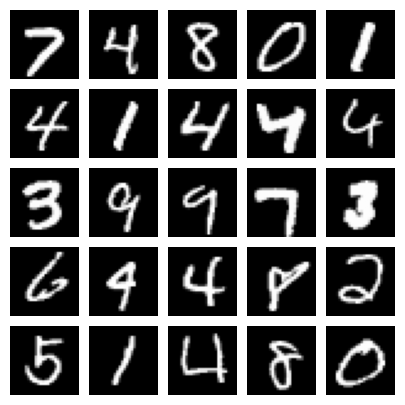

In [3]:
# Get 25 sample training images for visualisation
dataiter = iter(train_loader)
image = dataiter.__next__()

num_samples = 25
sample_images = [image[0][i, 0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

## VAE Implementation

Now, we can implement the VAE.

In [17]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
        )

        # Latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)      # Two dimension for both x and y axis
        self.logvar_layer = nn.Linear(latent_dim, 2)    # Two dimension for both x an y axis

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparametrization(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std).to(device)
        z = mean + std * epsilon
        return z

    def decode(self, x) -> torch.Tensor:
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparametrization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

## Training

Now, we can define the optimiser and the model.

In [5]:
model = VAE().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

### Loss Function

The loss function consists of the two loss:
1. Reproduction Loss (Reconstruction Loss)
2. Kullback-Leibler (KL) divergence

In [6]:
def loss_function(x, x_hat, mean, log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reconstruction_loss + kld

### Trainer

This is the trainer.

In [7]:
def train(model: torch.nn.Module, optimizer: torch.optim.Optimizer, epochs: int, device: str):
    model.train()
    epoch_losses = []
    
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(x.size(0), -1).to(device)
            
            optimizer.zero_grad()
            
            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()
        
        average_loss = overall_loss / (len(train_loader.dataset))
        epoch_losses.append(average_loss)
        print(f"\tEpoch {epoch + 1} \tAverage Loss: {average_loss}")
    return epoch_losses

In [8]:
epoch_losses = []

In [13]:
epoch_losses.extend(train(model, optimizer, epochs=50, device=device))

	Epoch 1 	Average Loss: 137.428388671875
	Epoch 2 	Average Loss: 137.3442067220052
	Epoch 3 	Average Loss: 137.38929016927082
	Epoch 4 	Average Loss: 137.20546499023436
	Epoch 5 	Average Loss: 137.21840481770835
	Epoch 6 	Average Loss: 137.2341313313802
	Epoch 7 	Average Loss: 137.24030779622396
	Epoch 8 	Average Loss: 137.20671446940105
	Epoch 9 	Average Loss: 137.19163028971354
	Epoch 10 	Average Loss: 137.03800149739584
	Epoch 11 	Average Loss: 137.1751500813802
	Epoch 12 	Average Loss: 137.0276606608073
	Epoch 13 	Average Loss: 137.030575390625
	Epoch 14 	Average Loss: 137.14716591796875
	Epoch 15 	Average Loss: 137.01149645182292
	Epoch 16 	Average Loss: 136.9411357747396
	Epoch 17 	Average Loss: 136.98741713867187
	Epoch 18 	Average Loss: 136.78497998046876
	Epoch 19 	Average Loss: 136.93397294921874
	Epoch 20 	Average Loss: 136.96832125651042
	Epoch 21 	Average Loss: 136.79784591471355
	Epoch 22 	Average Loss: 136.9229704264323
	Epoch 23 	Average Loss: 136.73977084960939
	Epoch 

In [15]:
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

TypeError: object of type 'float' has no len()

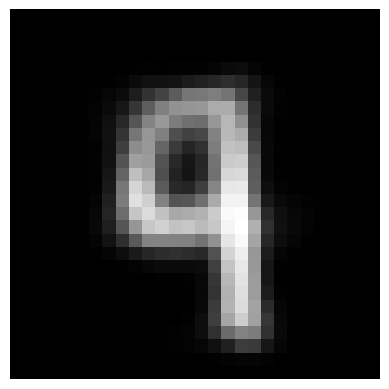

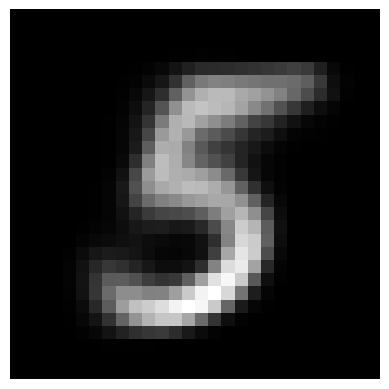

(None, None)

In [18]:
def generate_digit(x, y):
    z_sample = torch.tensor([[x, y]], dtype=torch.float32).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28)
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

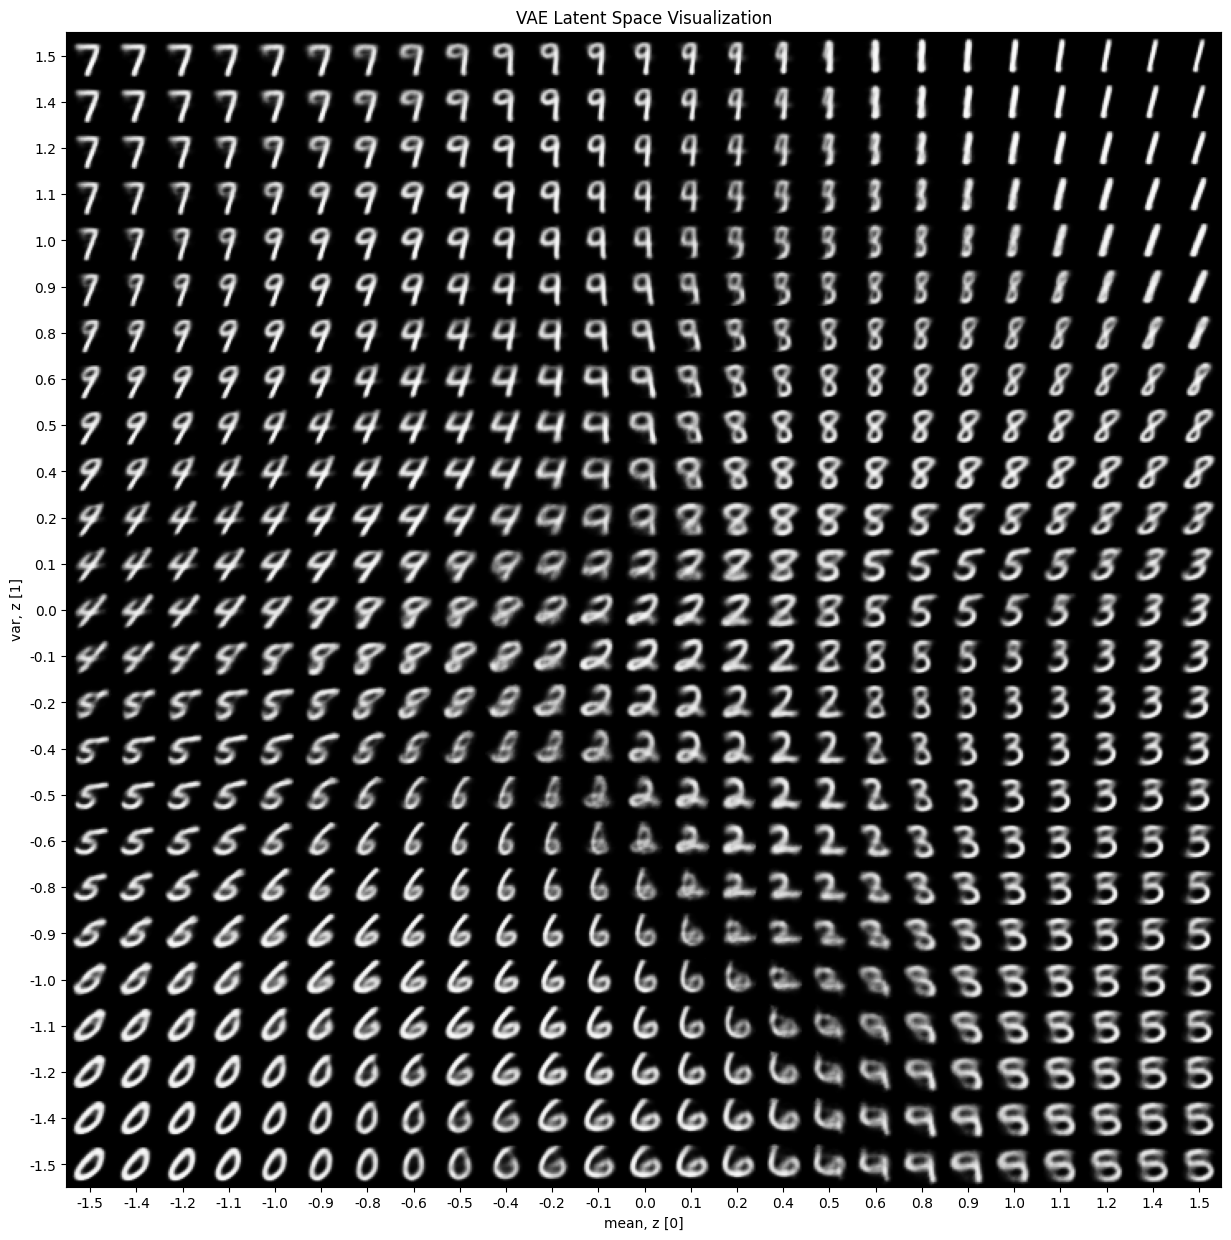

In [21]:
def plot_latent_space(model, scale = 1.0, n=25, digit_size=28, fig_size=15):
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(fig_size, fig_size))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()
    
plot_latent_space(model, scale=1.5)

In [24]:
torch.save(model.state_dict(), 'vae.pt')